<a href="https://colab.research.google.com/github/aralbright/2021_AAMSME/blob/main/notebooks/Differential_Expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differential expression

Input: adata_corrected.h5ad

Result: Volcano Plots, Upset Plot, Single Gene Plots, Mean DE Expression

In [1]:
!pip install anndata
!pip install diffxpy

     |████████████████████████████████| 96 kB 2.1 MB/s 
     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 140 kB 7.4 MB/s 
     |████████████████████████████████| 77 kB 6.7 MB/s 


In [2]:
# Import packages and setup 

import anndata
from anndata import AnnData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import diffxpy.api as de
from statsmodels.sandbox.stats.multicomp import multipletests

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load adata

In [3]:
!wget https://datadryad.org/stash/downloads/file_stream/1451480 -O adata_corrected.h5ad

--2022-04-27 23:18:01--  https://datadryad.org/stash/downloads/file_stream/1451480
Resolving datadryad.org (datadryad.org)... 100.20.51.141, 34.212.247.214
Connecting to datadryad.org (datadryad.org)|100.20.51.141|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dryad-assetstore-merritt-west.s3.us-west-2.amazonaws.com/ark%3A/13030/m5z66zg8%7C4%7Cproducer/adata_corrected.h5ad?response-content-type=application%2Fx-hdf&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEA8aCXVzLXdlc3QtMiJIMEYCIQDRR2anc3mj7XgPYFoyYKEvkbrq537iZnrMxWY7Zbk2aQIhAMkTsOgXHNvbqaLUDCBTzbpoHUqAex9J0Z%2BOw0QwZG37KtsECMj%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEQABoMNDUxODI2OTE0MTU3IgwBaRxjjOnqcVdRInwqrwRuNXBcnsUY6YNfgpDQcEXOKR8866sqanySE4PZsaayBGUYWE1lQmy8nEZ9R81hPsQ2n4EK%2BcC4PbjEdfvPvLcnpVhZALVL58aLAuwHEyL04EIF8PowP95kDYfG%2FVfisvS2O91GZJ0AlZRElleM3qxye79peIL2DCEaEVF98VBz9YLCTiBgVrZlz5KUN%2FHUgHfjFuOkpoe8yqXsQ8kJ5uIaBgmfFL7VePdDT3fcWgSo5Agz4Yu1YGdd9vNAVsx2pWi9OAtIR8TUUGPCvkbcjFOUFy1Ue%2FtaykROG7RaBpu

In [4]:
# Load AnnData
adata = anndata.read_h5ad("adata_corrected.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 8400 × 6000
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'dendrogram_leiden_scVI', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'X_scvi_norm', 'X_scvi_raw', 'log1p', 'norm', 'norm_log_unscaled', 'raw', 'scvi_norm_log'
    obsp: 'connectivities', 'distances'

In [6]:
# remove mitochondrial and ribosomal genes
riboS = adata.var["gene"].str.startswith('RpS')
riboS = riboS.astype(bool)

riboL = adata.var["gene"].str.startswith('RpL')
riboL = riboL.astype(bool)

mriboS = adata.var["gene"].str.startswith('mRpS')
mriboS = mriboS.astype(bool)

mriboL = adata.var["gene"].str.startswith('mRpL')
mriboL = mriboL.astype(bool)

mito_genes = adata.var["gene"].str.startswith('mt:')
mito_genes = mito_genes.astype(bool)

badgenes = (riboS | riboL | mito_genes | riboS | riboL)

adata = adata[:, ~badgenes]

In [7]:
adata

View of AnnData object with n_obs × n_vars = 8400 × 5910
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'dendrogram_leiden_scVI', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'X_scvi_norm', 'X_scvi_raw', 'log1p', 'norm', 'norm_log_unscaled', 'raw', 'scvi_norm_log'
    obsp: 'connectivities', 'distances'

## Differential expression within each cluster

In [8]:
adata.X = adata.layers['X_scvi_raw']

In [9]:
adata.obs.leiden_scVI.unique()

['2', '0', '5', '9', '3', '6', '1', '4', '8', '7']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [10]:
clusters = sorted(adata.obs.leiden_scVI.unique())
subs = {}
tests = {}
dfs = {}
sig_dfs = {}
corr_dfs = {}

# subset adata according to cluster 
for i in clusters: 
    
    # subset adata 
    
    name = i
    subs[name] = subs.get(name, adata[adata.obs['leiden_scVI'] == i])
    
subs['bulk'] = adata
    
# for each subset adata, run t-test between control and ctcf    
for sub in subs:     
    
    # run t-test between batches 
    
    ttest = 'test_tt_{}'.format(sub)
    tests[ttest] = de.test.t_test(data = subs[sub], grouping = 'batch')
    
# for each t-test, get the summary dataframe
for test in tests: 
    
    # get summary df 
    df = 'df_{}'.format(test)
    dfs[df] = tests[test].summary()
    
    # add cluster number to a column
    dfs[df]['cluster'] = df[-1]
    
# for each dataframe, bonferroni correct the p-value and filter for significance
for df in dfs: 
    
    # adjust p value 
    
    adj = multipletests(dfs[df]['pval'], alpha = 0.05, method='bonferroni')
    dfs[df]['padj'] = adj[1]
        
    # is significant? 

    dfs[df]['is_sig'] = ((dfs[df]['padj'] <= 0.05) & (abs(dfs[df]['log2fc']) >= 1.5))
       
    # filter for significance     
    
    sig_dfs[df] = dfs[df].loc[dfs[df]['is_sig'] == True]

    
for sig in sig_dfs: 
    
    # add cluster number as column 
    #sig_dfs[sig]['cluster'] = sig[-1]
    
    # correct the p-value for the number of upset comparisons
    sig_dfs[sig]['pcorr'] = (sig_dfs[sig]['padj'] * (len(clusters) + 1))
    
    # filter for significance into a final dictionary of genes to plot
    corr_dfs[sig] = sig_dfs[sig][(sig_dfs[sig]['pcorr'] <= 0.05)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
# merge all dfs in corr_dfs into one df 

frames = corr_dfs.values()

In [12]:
df_to_plot = pd.concat(frames)

In [13]:
dfs

{'df_test_tt_0':                      gene           pval           qval    log2fc       mean  \
 0         Su(Ste):CR42418   3.780738e-69   3.940769e-68  3.405483   0.022719   
 1                 CG40635   2.613213e-07   3.646774e-07  0.871583   0.001631   
 2          lncRNA:CR40719   3.320778e-02   3.785841e-02 -0.182472   0.004695   
 3                    Adhr   3.663610e-17   6.908723e-17 -0.636538   0.000918   
 4                 CG11929   1.370963e-57   9.012671e-57  1.522816   0.189578   
 ...                   ...            ...            ...       ...        ...   
 5905              CR41506   5.034787e-24   1.149752e-23  1.116461   0.001911   
 5906  28SrRNA-Psi:CR40596   3.070785e-64   2.596329e-63  1.115958   1.886861   
 5907      28SrRNA:CR45837   2.148435e-87   5.140586e-86  1.238026   6.562744   
 5908     pre-rRNA:CR45846  1.229648e-122  2.076348e-120  2.094525  36.190353   
 5909      28SrRNA:CR45844   1.582186e-70   1.754356e-69  1.004275   9.348917   
 
       zer

## Volcano Plot

In [14]:
for df in dfs: 
    
    dfs[df]['volcano_y'] = -np.log10(dfs[df]['padj'])
    

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
locals().update(dfs)

In [16]:
dfs.keys()

dict_keys(['df_test_tt_0', 'df_test_tt_1', 'df_test_tt_2', 'df_test_tt_3', 'df_test_tt_4', 'df_test_tt_5', 'df_test_tt_6', 'df_test_tt_7', 'df_test_tt_8', 'df_test_tt_9', 'df_test_tt_bulk'])

Cluster 0

In [17]:
xs = df_test_tt_0['log2fc']
ys = df_test_tt_0['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

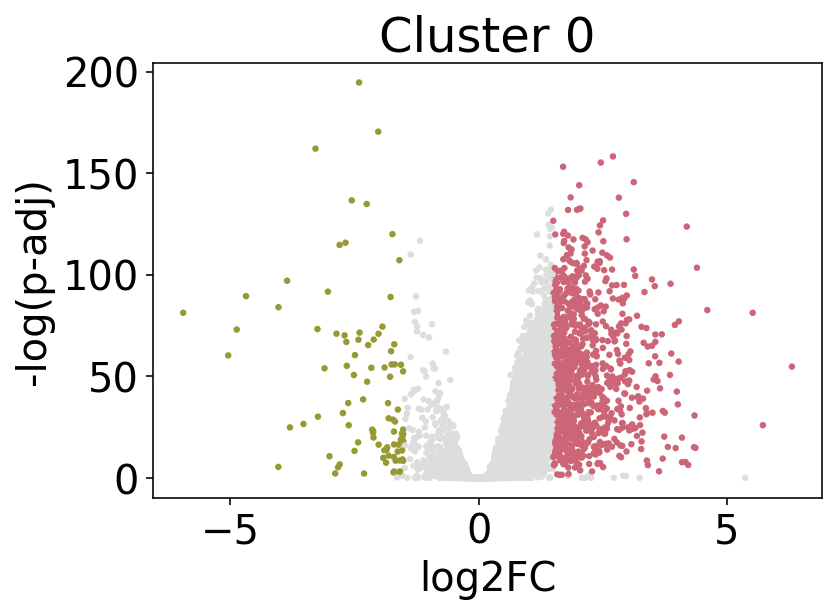

In [18]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 0')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster0.png', dpi = 400)

Cluster 1

In [19]:
xs = df_test_tt_1['log2fc']
ys = df_test_tt_1['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

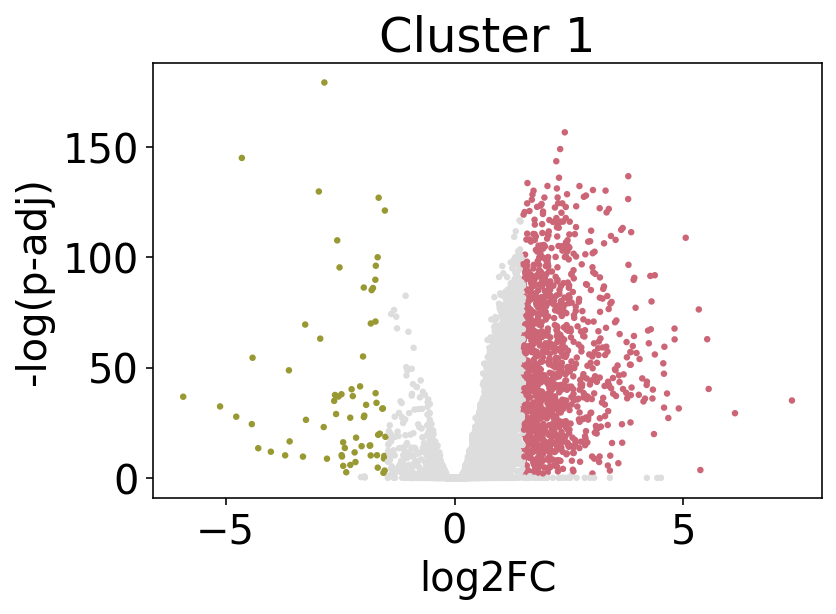

In [20]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 1')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster1.png', dpi = 400)

Cluster 2

In [21]:
xs = df_test_tt_2['log2fc']
ys = df_test_tt_2['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

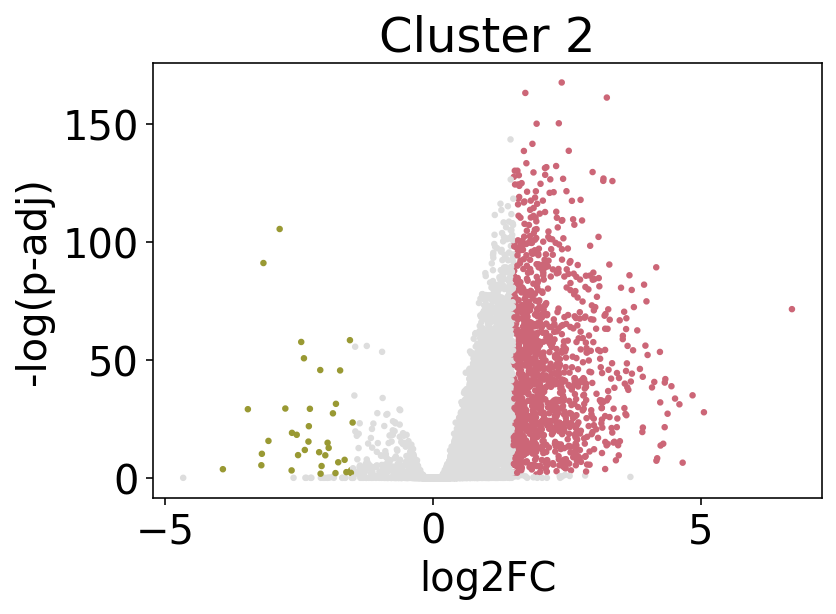

In [22]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 2')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster2.png', dpi = 400)

Cluster 3

In [23]:
xs = df_test_tt_3['log2fc']
ys = df_test_tt_3['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

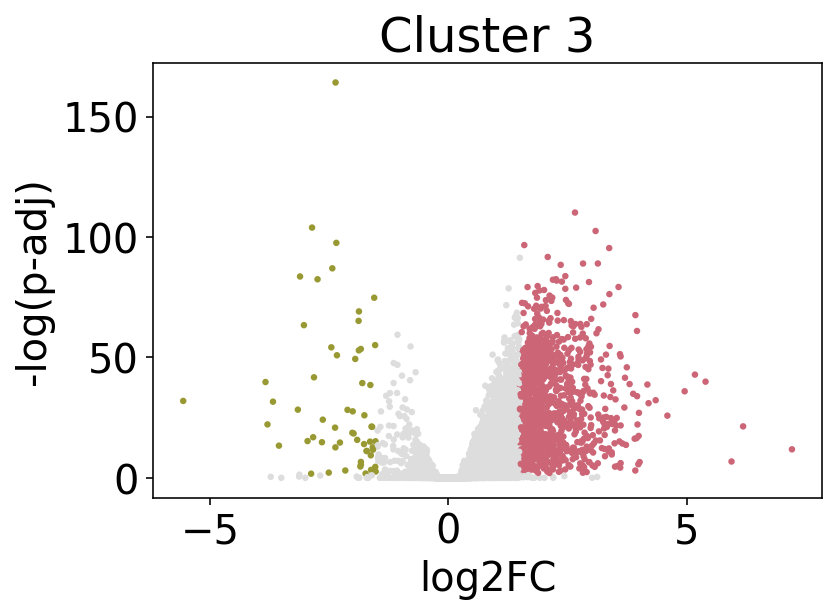

In [24]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 3')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster3.png', dpi = 400)

Cluster 4

In [25]:
xs = df_test_tt_4['log2fc']
ys = df_test_tt_4['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

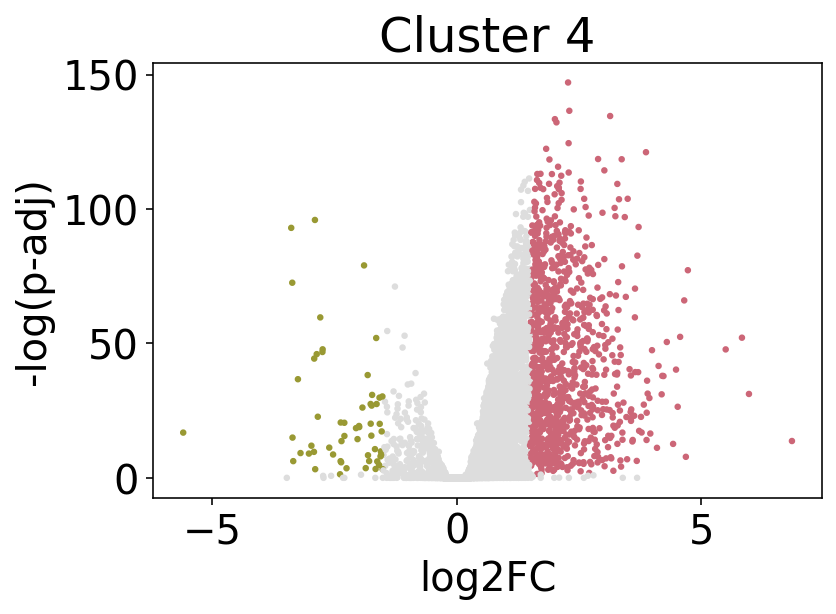

In [26]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 4')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster4.png', dpi = 400)

Cluster 5

In [27]:
xs = df_test_tt_5['log2fc']
ys = df_test_tt_5['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

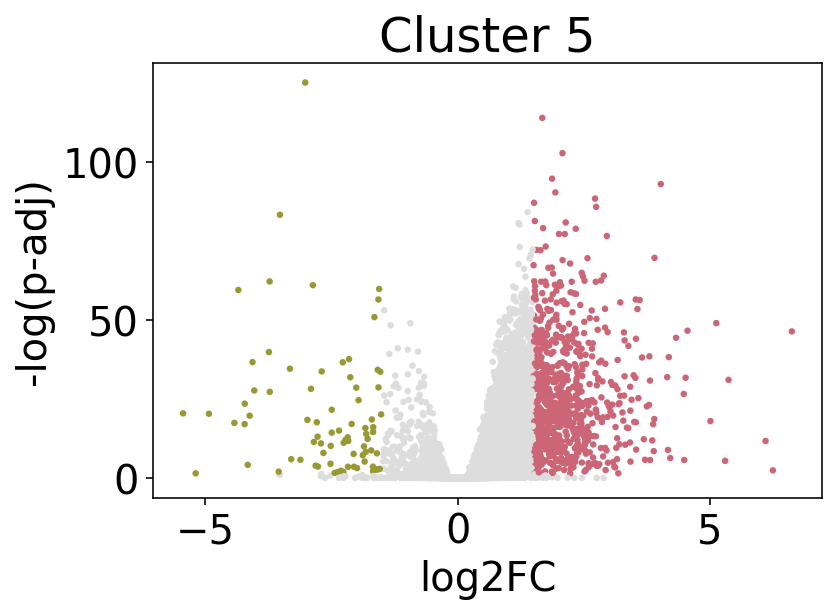

In [28]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 5')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster5.png', dpi = 400)

Cluster 6

In [29]:
xs = df_test_tt_6['log2fc']
ys = df_test_tt_6['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

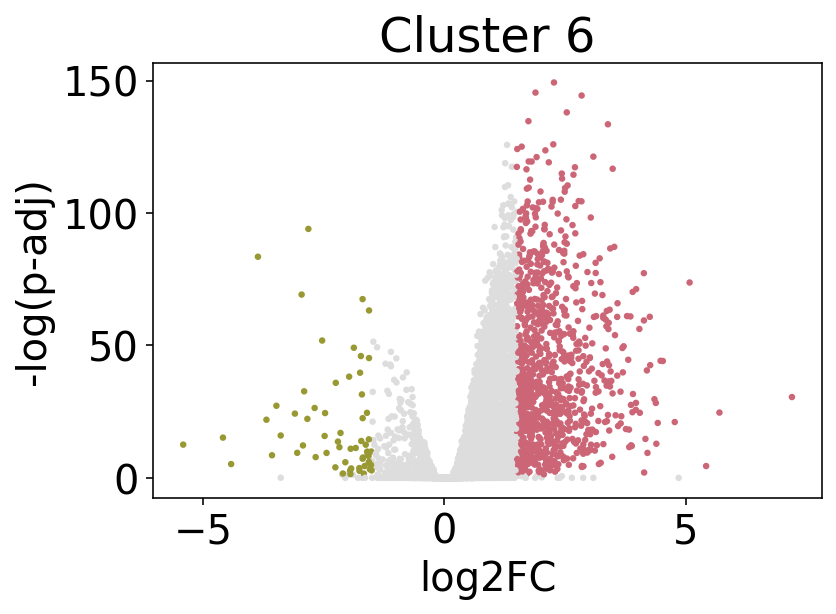

In [30]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 6')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster6.png', dpi = 400)

Cluster 7

In [31]:
xs = df_test_tt_7['log2fc']
ys = df_test_tt_7['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

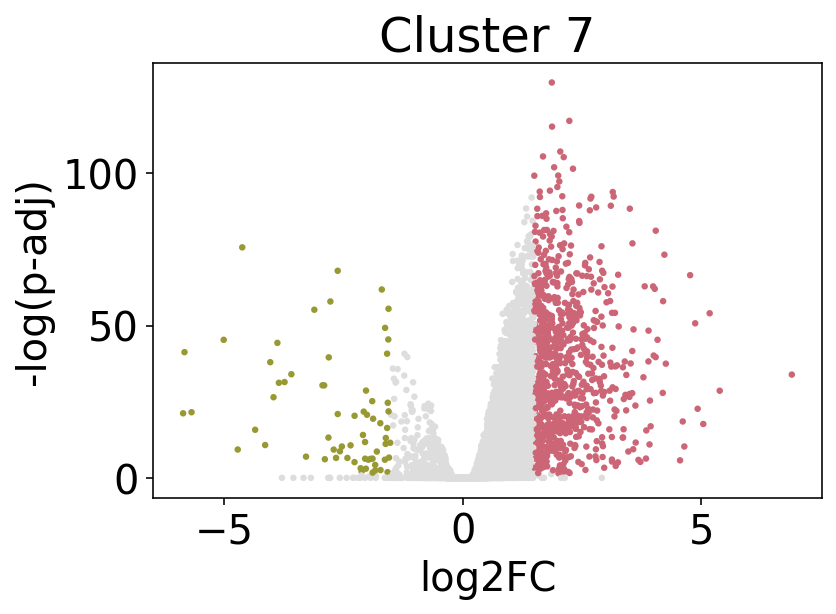

In [32]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 7')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster7.png', dpi = 400)

Cluster 8

In [33]:
xs = df_test_tt_8['log2fc']
ys = df_test_tt_8['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

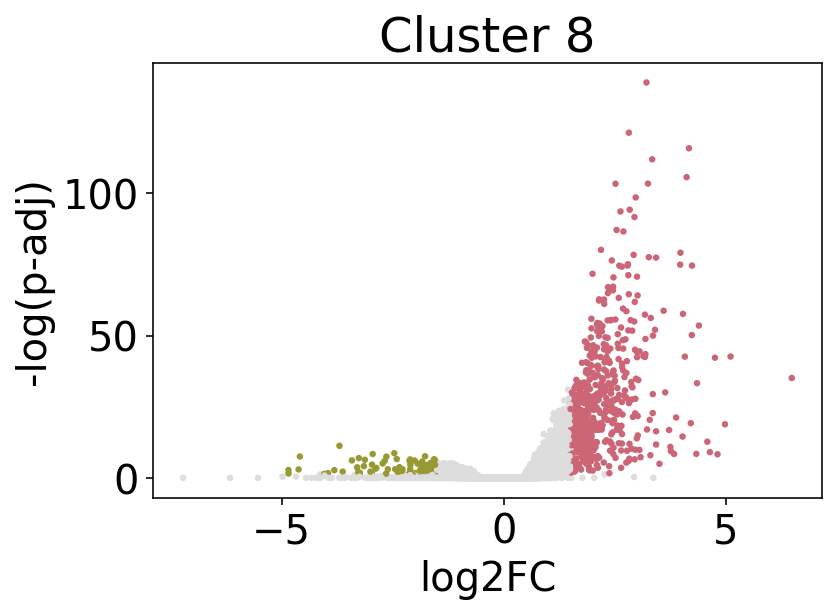

In [34]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 8')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster8.png', dpi = 400)

Cluster 9

In [35]:
xs = df_test_tt_9['log2fc']
ys = df_test_tt_9['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

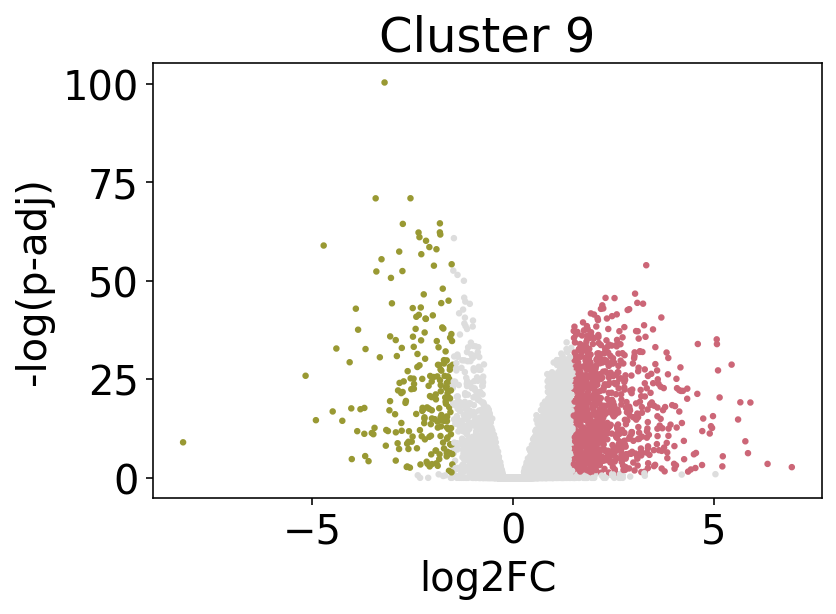

In [36]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 9')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster9.png', dpi = 400)

Bulk

In [37]:
xs = df_test_tt_bulk['log2fc']
ys = df_test_tt_bulk['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

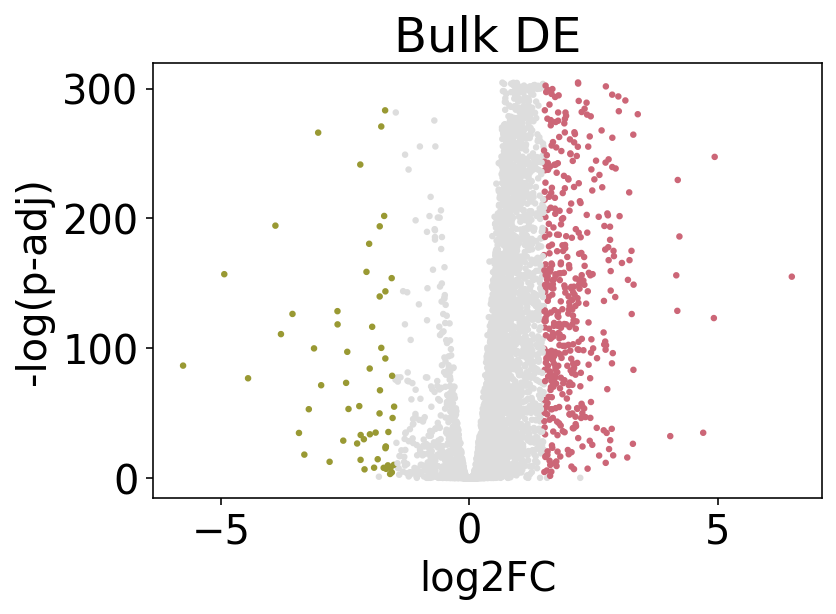

In [38]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Bulk DE')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('bulk.png', dpi = 400)

## UpSet Plot

In [39]:
df_to_plot

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,cluster,padj,is_sig,pcorr
0,Su(Ste):CR42418,3.780738e-69,3.940769e-68,3.405483,0.022719,False,False,0,2.234416e-65,True,2.457858e-64
4,CG11929,1.370963e-57,9.012671e-57,1.522816,0.189578,False,False,0,8.102391e-54,True,8.912630e-53
20,bdl,1.790376e-38,6.313318e-38,1.501100,0.004348,False,False,0,1.058112e-34,True,1.163923e-33
24,l(2)k05819,4.557300e-76,6.750286e-75,2.087143,0.024437,False,False,0,2.693364e-72,True,2.962701e-71
29,ine,4.969613e-36,1.638974e-35,1.726051,0.003608,False,False,0,2.937041e-32,True,3.230746e-31
...,...,...,...,...,...,...,...,...,...,...,...
5881,upd2,4.726651e-244,2.613144e-243,2.871833,0.033199,False,False,k,2.793451e-240,True,3.072796e-239
5882,xmas,0.000000e+00,0.000000e+00,1.839427,0.056584,False,False,k,0.000000e+00,True,0.000000e+00
5884,CR46425,0.000000e+00,0.000000e+00,3.080460,0.002596,False,False,k,0.000000e+00,True,0.000000e+00
5886,Ir7g,2.639081e-139,7.885223e-139,2.191332,0.011131,False,False,k,1.559697e-135,True,1.715667e-134


In [40]:
df_to_plot.to_csv('deGenesDF.csv')

In [41]:
# activate R magic
%load_ext rpy2.ipython

In [42]:
%%R
install.packages("UpSetR",repos = "http://cran.us.r-project.org")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘Rcpp’, ‘gridExtra’, ‘plyr’


R[write to console]: trying URL 'http://cran.us.r-project.org/src/contrib/Rcpp_1.0.8.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 3086192 bytes (2.9 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to

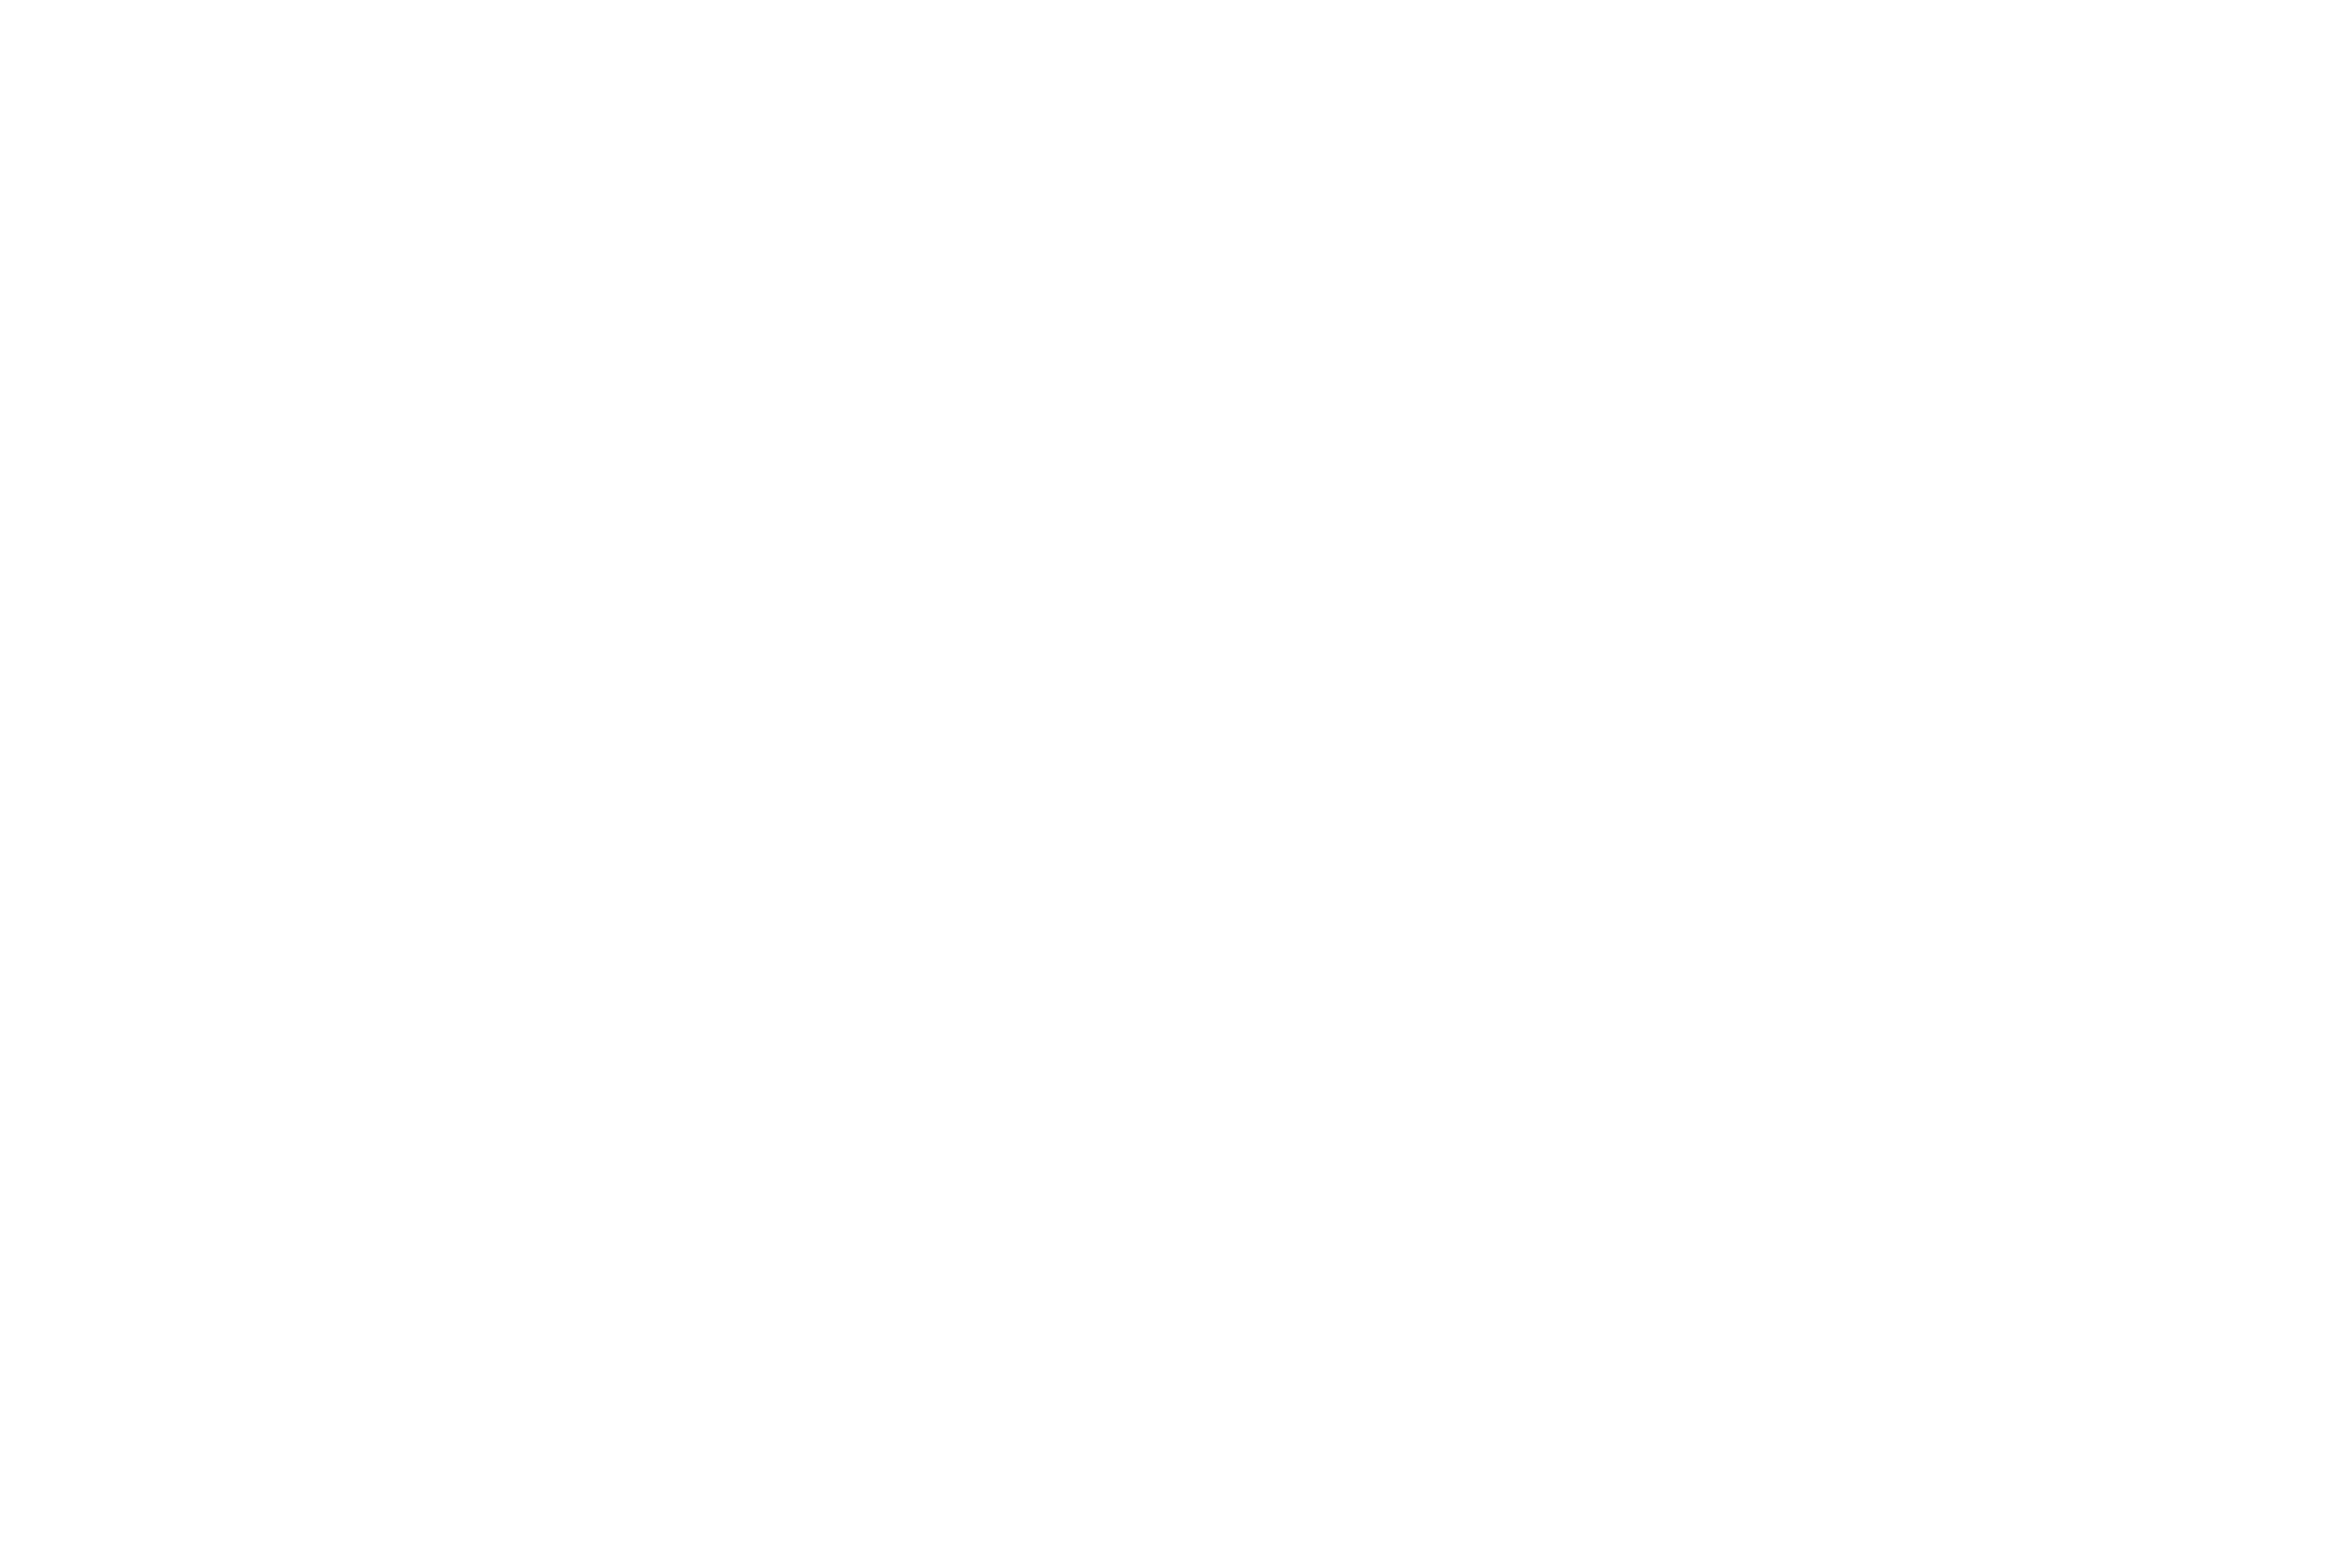

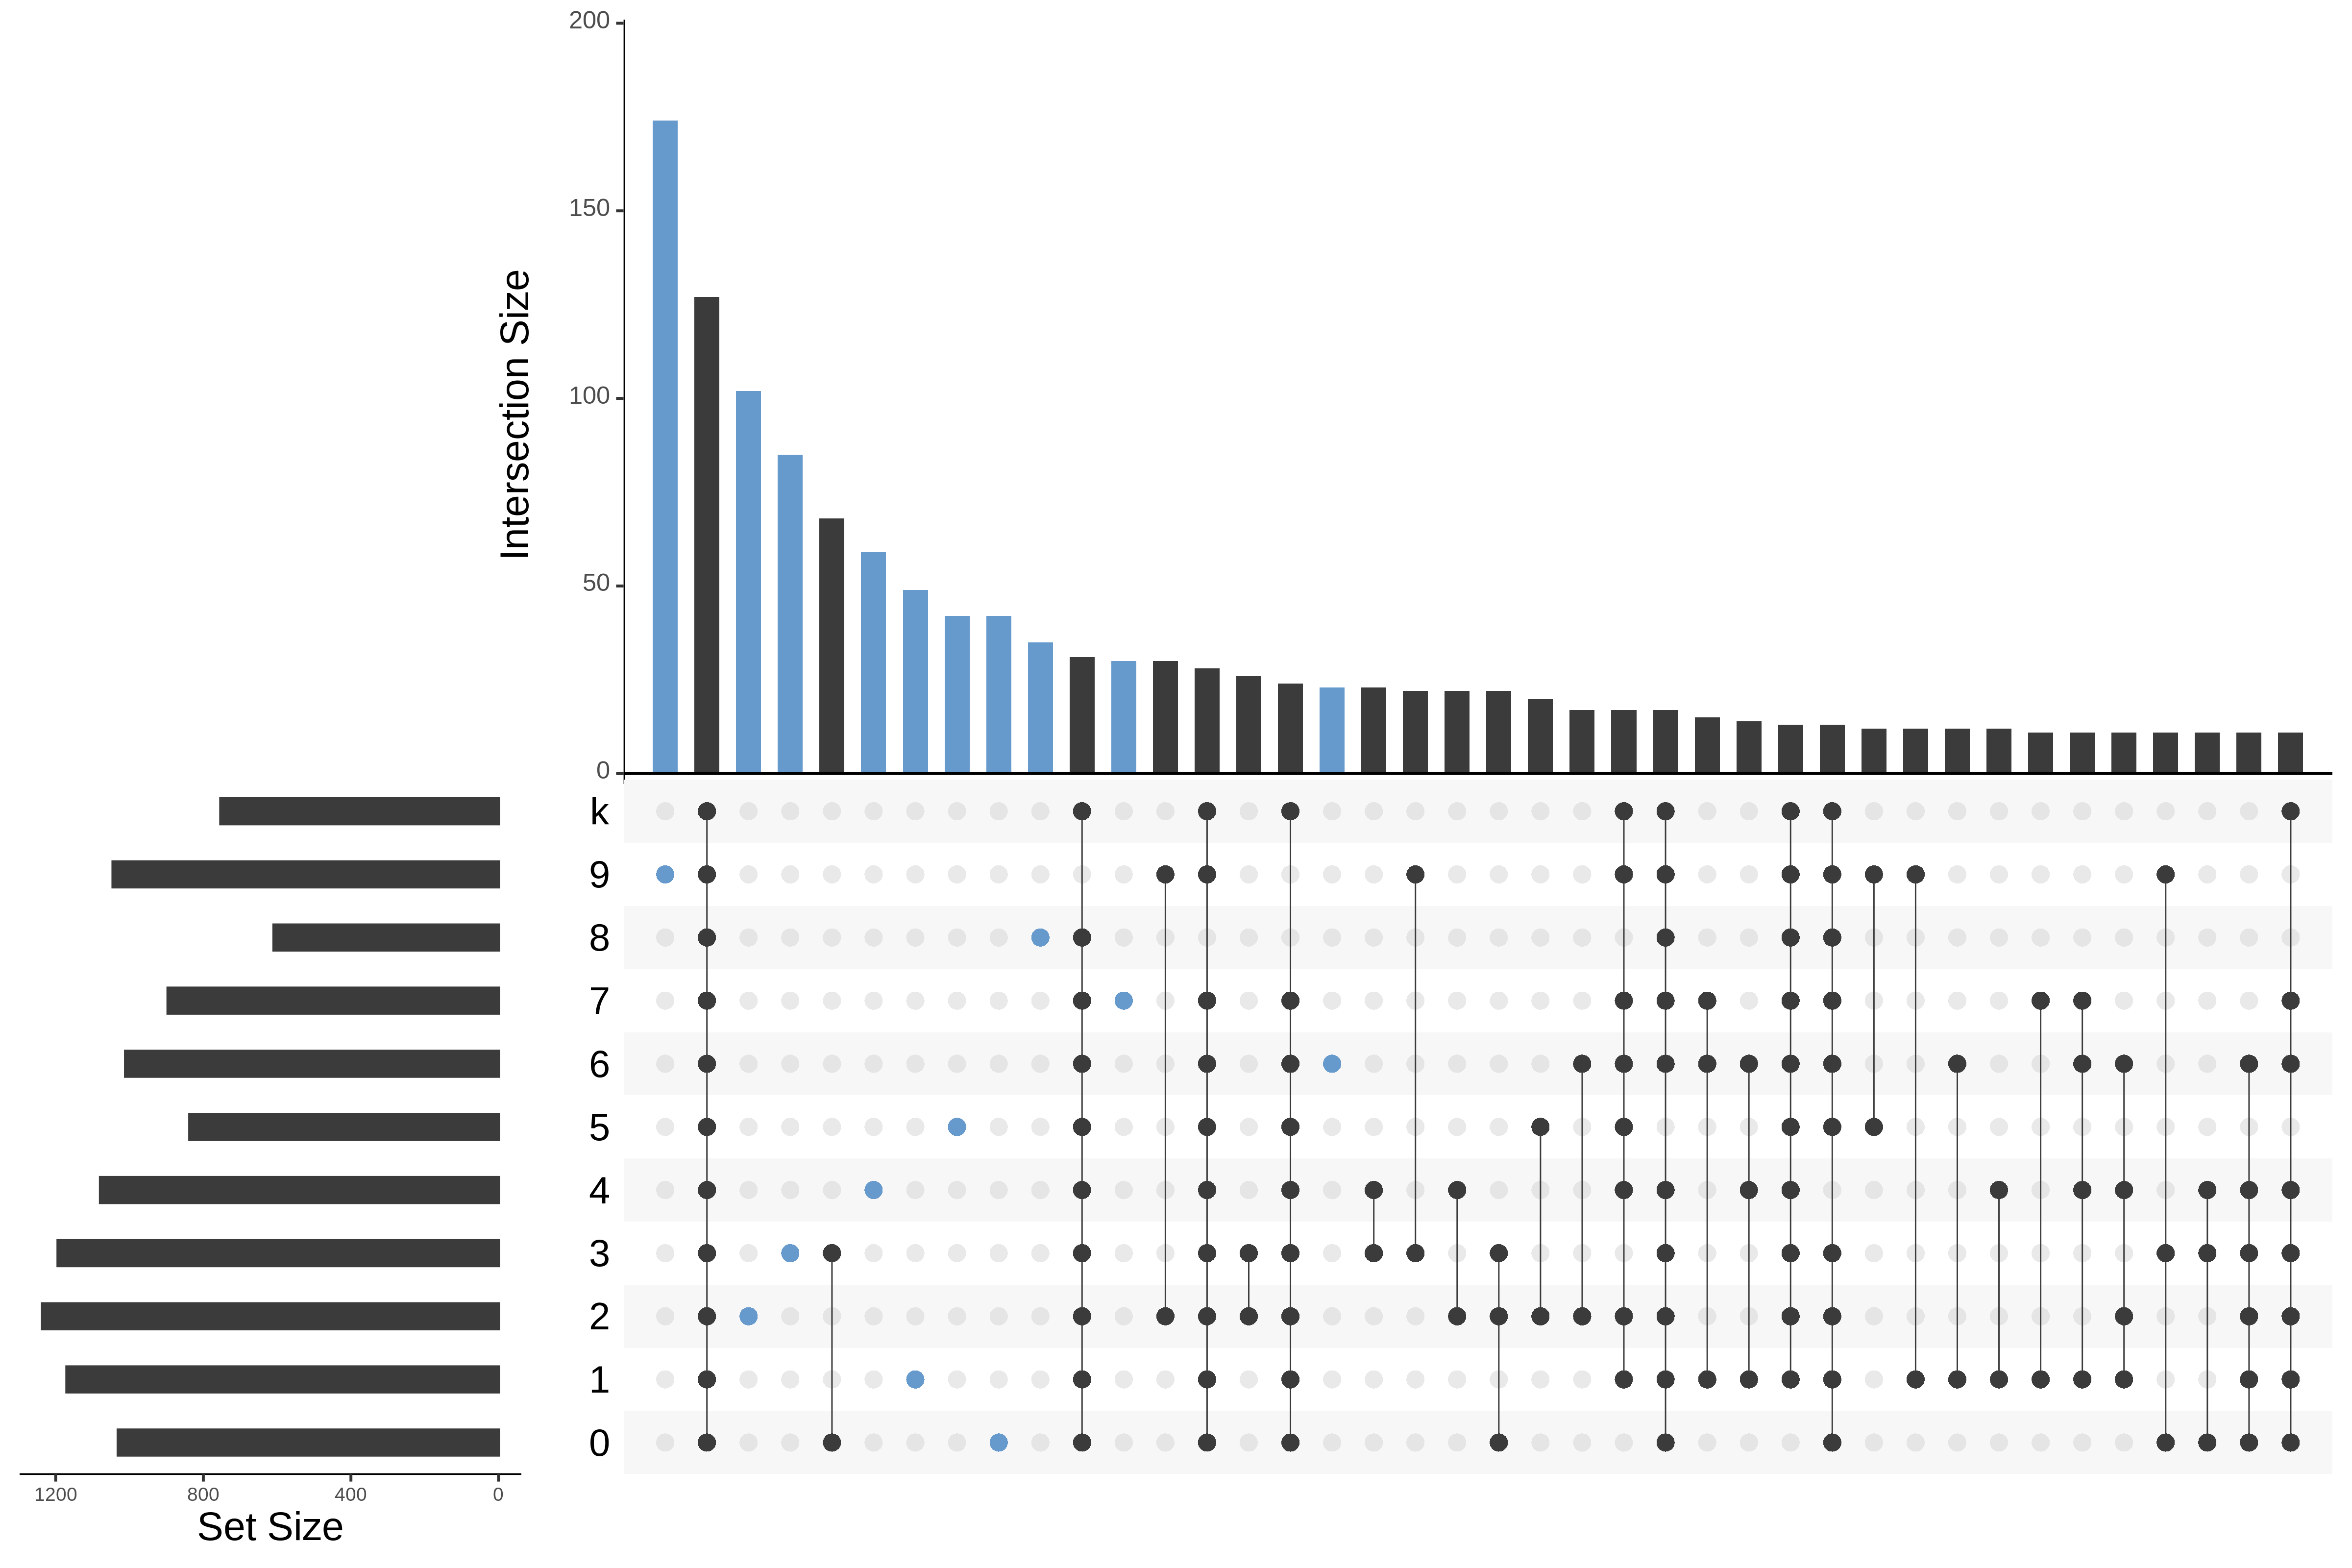

In [43]:
%%R -w 12 -h 8 --units in -r 400
library("UpSetR")
library("ggplot2")

deGenesDF <- read.csv("deGenesDF.csv")

vecsToPlot <- list()

clusters = unique(deGenesDF$cluster)

for (i in 1:length(clusters)){
  subset = subset(deGenesDF, cluster == clusters[i])
  vecsToPlot[[i]] <- unique(subset$gene)
}

names(vecsToPlot) <- clusters

upset(fromList(vecsToPlot), sets = as.character(clusters),nintersects=40, order.by = "freq",
      mainbar.y.label='Intersection Size',
      sets.x.label = 'Set Size',
      text.scale = c(1.75, 1.3, 1.75, 1, 2, 1.3),
      show.numbers = "no",
      point.size = 2.8,
      keep.order = TRUE, 
      line.size = 0.25,
      mb.ratio= c(0.5, 0.5),
      queries = list(list(query = intersects, params = list("0"), color = "#6699CC",active = T),
                     list(query = intersects, params = list("1"), color = "#6699CC",active = T),
                     list(query = intersects, params = list("2"), color = "#6699CC",active = T),
                     list(query = intersects, params = list("3"), color = "#6699CC",active = T),
                     list(query = intersects, params = list("4"), color = "#6699CC",active = T),
                     list(query = intersects, params = list("5"), color = "#6699CC",active = T),
                     list(query = intersects, params = list("6"), color = "#6699CC",active = T),
                     list(query = intersects, params = list("7"), color = "#6699CC",active = T),
                     list(query = intersects, params = list("8"), color = "#6699CC",active = T),
                     list(query = intersects, params = list("9"), color = "#6699CC",active = T)))

# just right click and save 

## Single Gene Plots

In [44]:
adata.X = adata.layers['norm_log_unscaled']

In [45]:
adata.obs['batch'] = adata.obs['batch'].replace({'0':'control', '1':'ctcf'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.


In [46]:
frames_forpval = dfs.values()

In [47]:
frame_forpval = pd.concat(frames_forpval)

Text(0.5, 1.0, 'stumps')

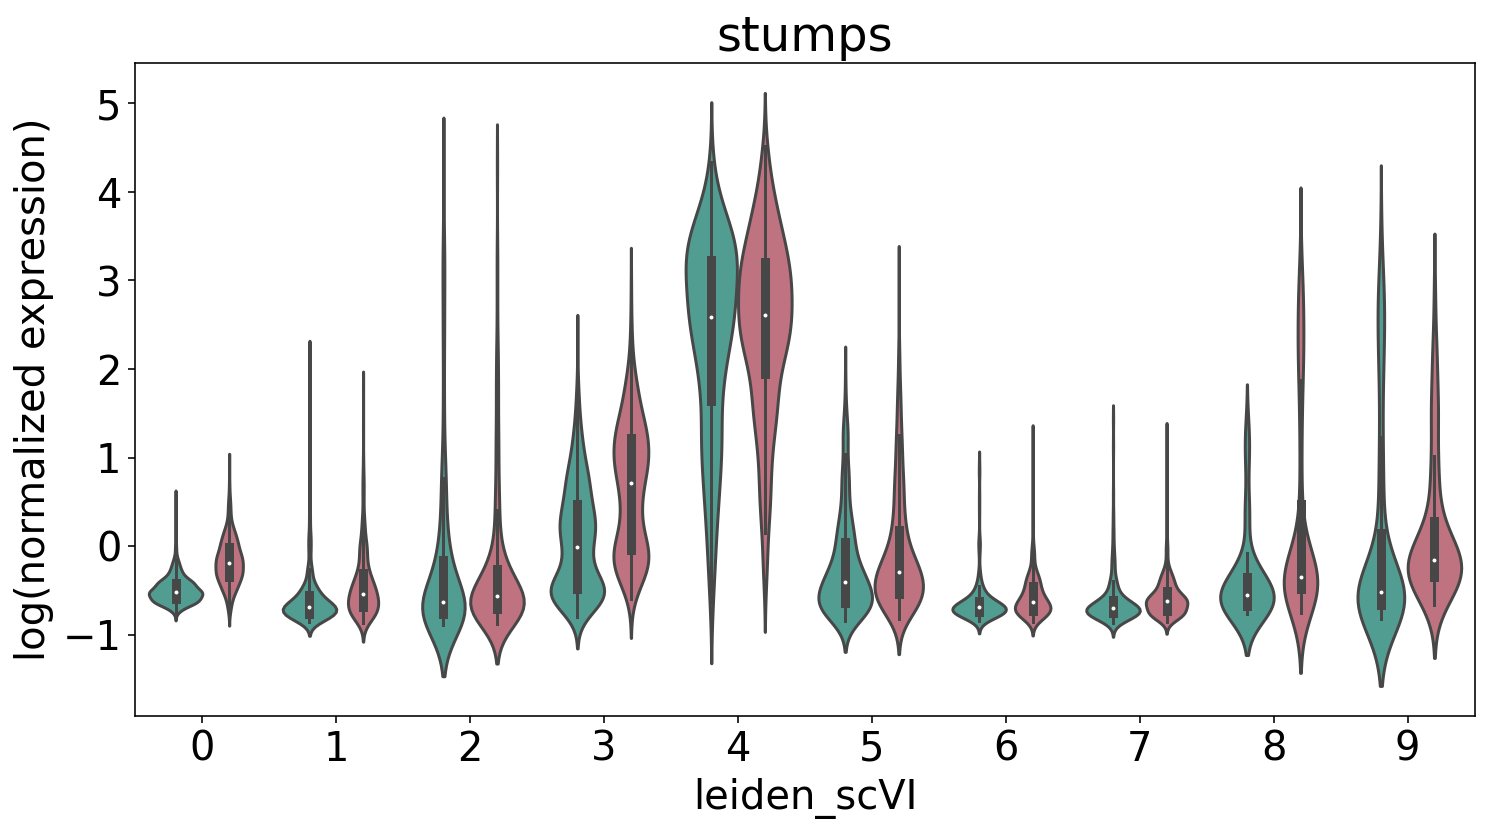

In [48]:
gene = "stumps"#@param {type:"string"}
x = adata.obs['leiden_scVI']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (12,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
ax.get_legend().remove()
ax.set_ylabel('log(normalized expression)')
ax.set_title(gene)

Text(0.5, 1.0, 'stumps')

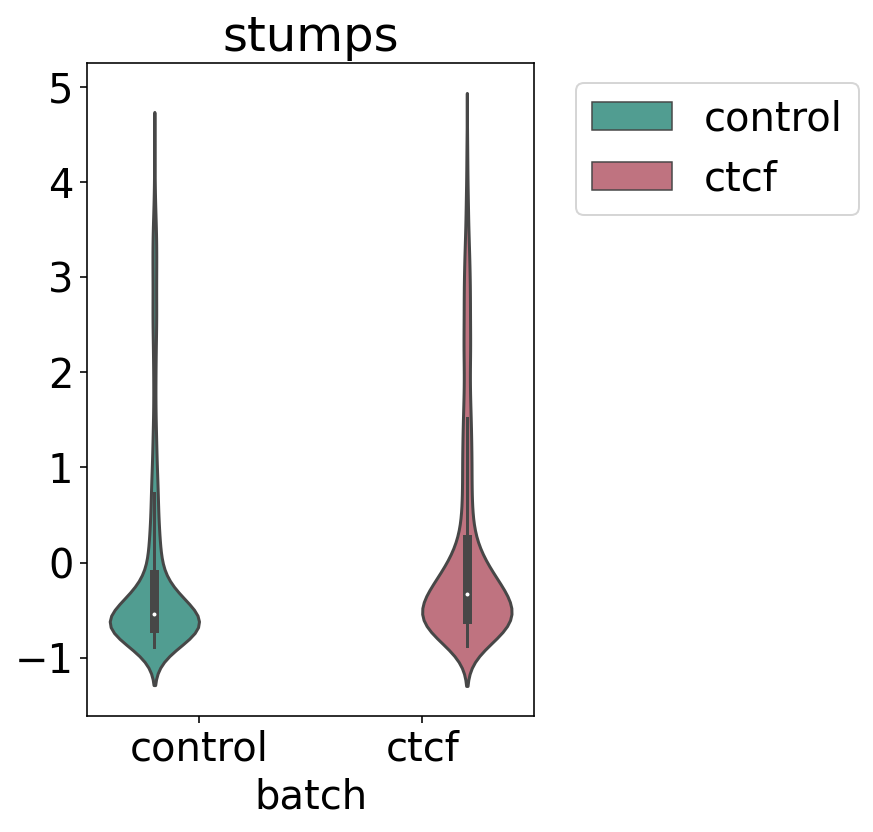

In [49]:
x = adata.obs['batch']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (4,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title(gene)

In [50]:
frame_forpval.loc[frame_forpval['gene'] == gene]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,cluster,padj,is_sig,volcano_y
3899,stumps,2.809200e-61,2.147784e-60,1.559519,0.102438,False,False,0,1.660237e-57,True,56.779830
3899,stumps,3.808213e-07,5.200216e-07,1.099736,0.117604,False,False,1,2.250654e-03,False,2.647691
3899,stumps,7.390392e-01,7.550081e-01,-0.131312,0.704379,False,False,2,1.000000e+00,False,-0.000000
3899,stumps,5.739195e-23,1.868796e-22,1.707367,0.517551,False,False,3,3.391864e-19,True,18.469562
3899,stumps,3.679890e-09,5.732248e-09,0.653141,9.474081,False,False,4,2.174815e-05,False,4.662578
3899,stumps,4.080635e-05,6.270554e-05,1.097435,0.275315,False,False,5,2.411655e-01,False,0.617685
3899,stumps,2.191393e-04,2.872284e-04,0.913641,0.091514,False,False,6,1.000000e+00,False,-0.000000
3899,stumps,1.467712e-02,1.806744e-02,0.714695,0.079234,False,False,7,1.000000e+00,False,-0.000000
3899,stumps,7.376555e-21,9.315264e-20,3.426343,0.673582,False,False,8,4.359544e-17,True,16.360559
3899,stumps,6.408828e-01,6.691904e-01,-0.215378,0.849499,False,False,9,1.000000e+00,False,-0.000000


Text(0.5, 1.0, 'bowl')

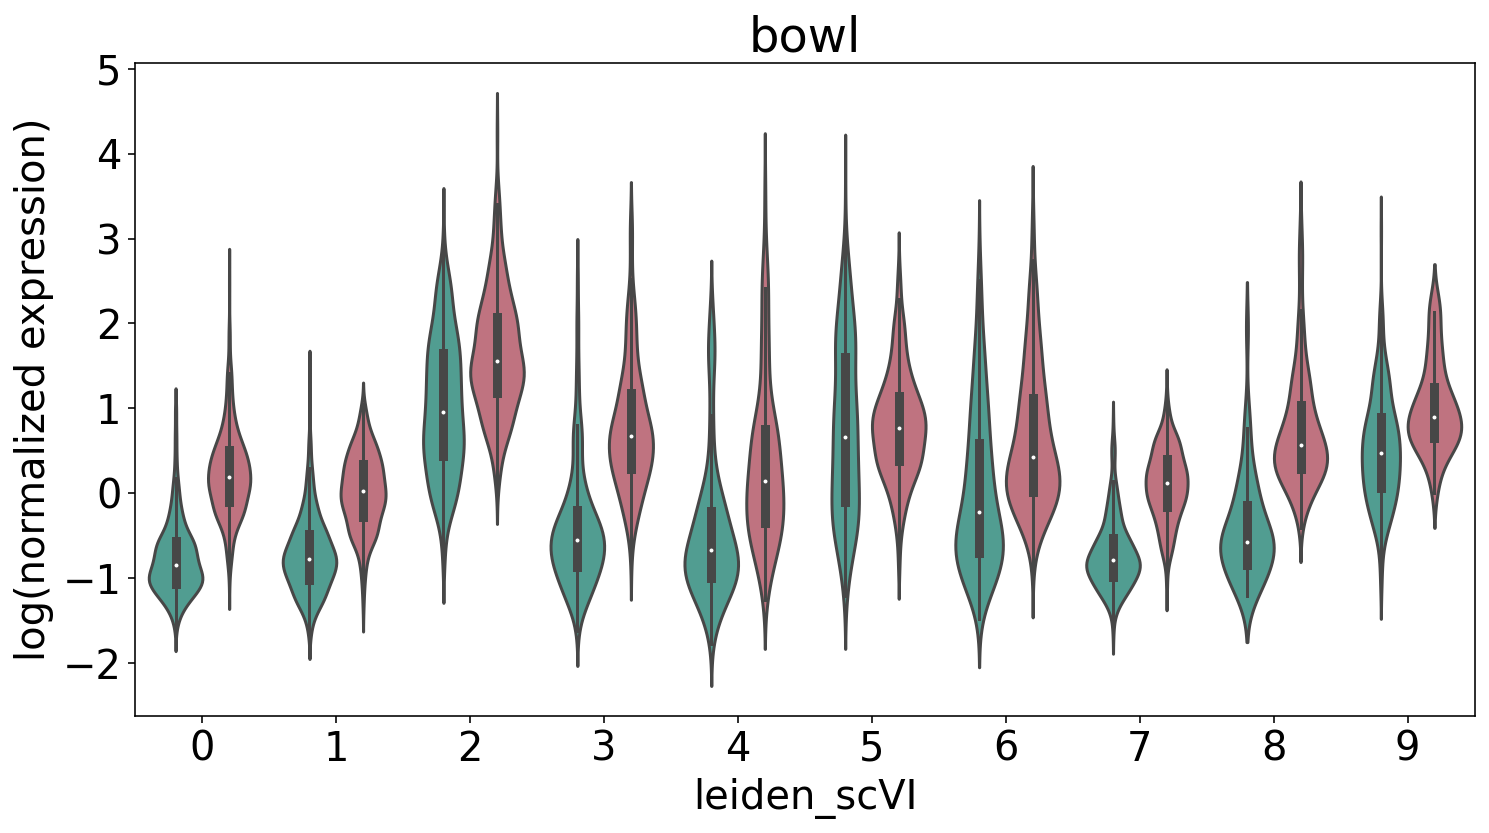

In [51]:
gene = "bowl"#@param {type:"string"}

x = adata.obs['leiden_scVI']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (12,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
ax.get_legend().remove()
ax.set_ylabel('log(normalized expression)')
ax.set_title(gene)

Text(0.5, 1.0, 'bowl')

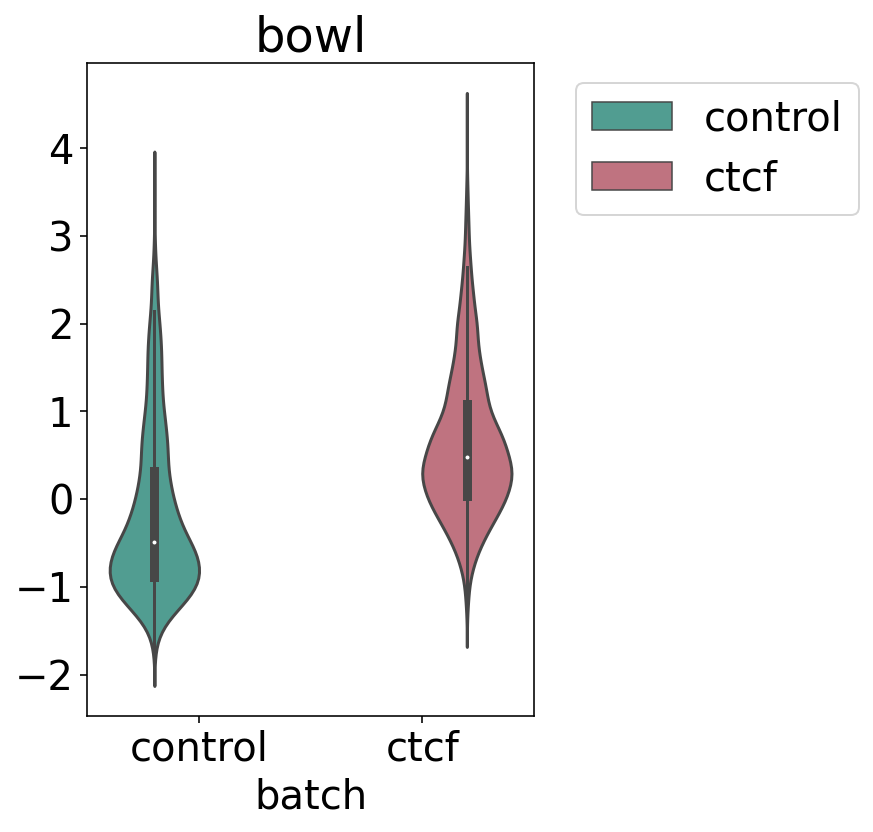

In [52]:
x = adata.obs['batch']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (4,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title(gene)

In [53]:
frame_forpval.loc[frame_forpval['gene'] == gene]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,cluster,padj,is_sig,volcano_y
43,bowl,7.077010e-57,4.521635e-56,1.871233,0.243896,False,False,0,4.182513e-53,True,52.378563
43,bowl,1.087251e-73,1.104064e-72,1.464298,0.324480,False,False,1,6.425654e-70,False,69.192083
43,bowl,2.660281e-45,1.151814e-44,1.193047,1.249572,False,False,2,1.572226e-41,False,40.803485
43,bowl,1.462246e-36,1.025133e-35,1.995756,0.417254,False,False,3,8.641874e-33,True,32.063392
43,bowl,3.652171e-27,1.025384e-26,1.612047,0.615450,False,False,4,2.158433e-23,True,22.665861
43,bowl,6.763177e-03,8.763512e-03,0.285240,0.668512,False,False,5,1.000000e+00,False,-0.000000
43,bowl,1.285272e-19,3.002356e-19,1.080495,0.724079,False,False,6,7.595960e-16,False,15.119417
43,bowl,1.222586e-56,2.052694e-55,1.436113,0.344720,False,False,7,7.225482e-53,False,52.141133
43,bowl,5.718132e-27,1.115319e-25,1.731728,0.458607,False,False,8,3.379416e-23,True,22.471158
43,bowl,8.229569e-09,1.693480e-08,0.695900,0.616105,False,False,9,4.863675e-05,False,4.313035


Text(0.5, 1.0, 'Esp')

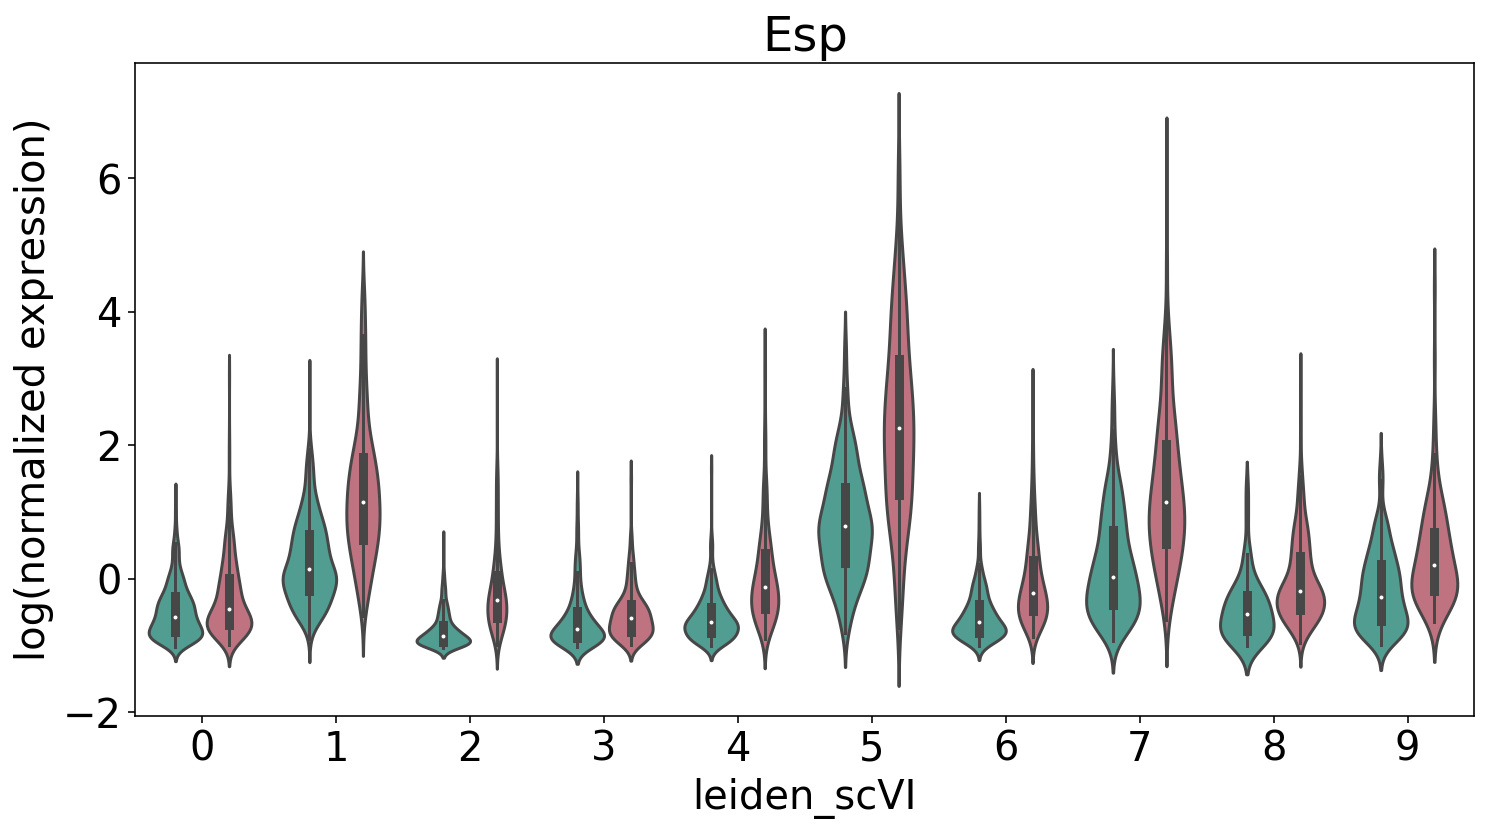

In [54]:
gene = "Esp"#@param {type:"string"}

x = adata.obs['leiden_scVI']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (12,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
ax.get_legend().remove()
ax.set_ylabel('log(normalized expression)')
ax.set_title(gene)

Text(0.5, 1.0, 'Esp')

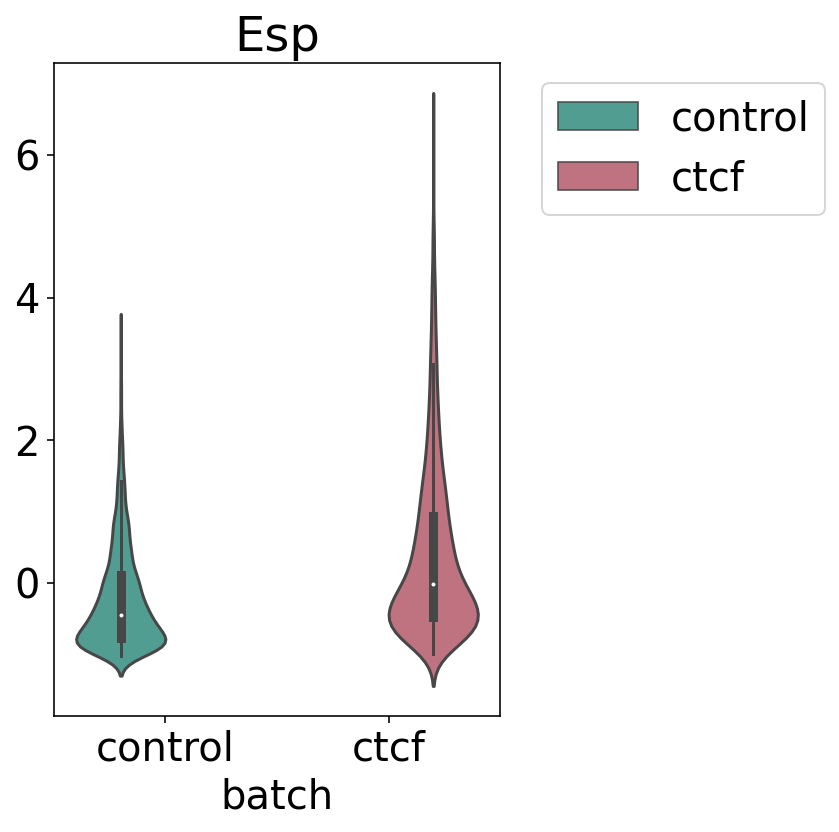

In [55]:
x = adata.obs['batch']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (4,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title(gene)

In [56]:
frame_forpval.loc[frame_forpval['gene'] == gene]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,cluster,padj,is_sig,volcano_y
4332,Esp,1.583211e-22,3.492638e-22,1.140830,0.018565,False,False,0,9.356778e-19,False,18.028874
4332,Esp,1.297883e-57,7.347210e-57,1.573672,0.090816,False,False,1,7.670488e-54,True,53.115177
4332,Esp,1.904178e-51,9.985528e-51,2.475537,0.028610,False,False,2,1.125369e-47,True,46.948705
4332,Esp,7.448962e-15,1.630495e-14,0.934869,0.013791,False,False,3,4.402337e-11,False,10.356317
4332,Esp,1.738605e-57,1.376753e-56,1.881628,0.040055,False,False,4,1.027515e-53,True,52.988212
4332,Esp,7.195112e-43,1.171436e-41,1.554251,0.110894,False,False,5,4.252311e-39,True,38.371375
4332,Esp,2.418004e-38,1.043095e-37,1.597806,0.036611,False,False,6,1.429040e-34,True,33.844956
4332,Esp,1.586986e-36,9.018355e-36,1.581272,0.095391,False,False,7,9.379089e-33,True,32.027839
4332,Esp,6.694384e-04,1.517599e-03,0.815108,0.024790,False,False,8,1.000000e+00,False,-0.000000
4332,Esp,3.953610e-04,5.760807e-04,1.055716,0.038828,False,False,9,1.000000e+00,False,-0.000000


## Mean Normalized Expression of DE and nonDE genes

In [57]:
appearances = pd.DataFrame(df_to_plot['gene'].value_counts())

In [58]:
appearances

,gene
Su(Ste):CR42418,11
cad,11
vg,11
Su(z)2,11
rut,11
...,...
E(spl)mgamma-HLH,1
tx,1
alpha-Man-Ib,1
Dr,1


In [59]:
single = list(appearances[appearances['gene'] == 1].index)

In [60]:
multi = list(appearances[appearances['gene'] != 1].index)

In [61]:
notDE = adata[:,~adata.var.gene.isin(single)]
notDE = notDE[:,~notDE.var.gene.isin(multi)]

In [62]:
# make sure numbers add up 
print(len(single))
print(len(multi))
print(len(notDE.var.gene))
print(len(adata.X.mean(axis=0)))

645
1942
3323
5910


In [63]:
single_adata = adata[:,adata.var.gene.isin(single)]
multi_adata = adata[:, adata.var.gene.isin(multi)]

In [64]:
single_adata.X = single_adata.layers['X_scvi_norm']
multi_adata.X = multi_adata.layers['X_scvi_norm']
notDE.X = notDE.layers['X_scvi_norm']

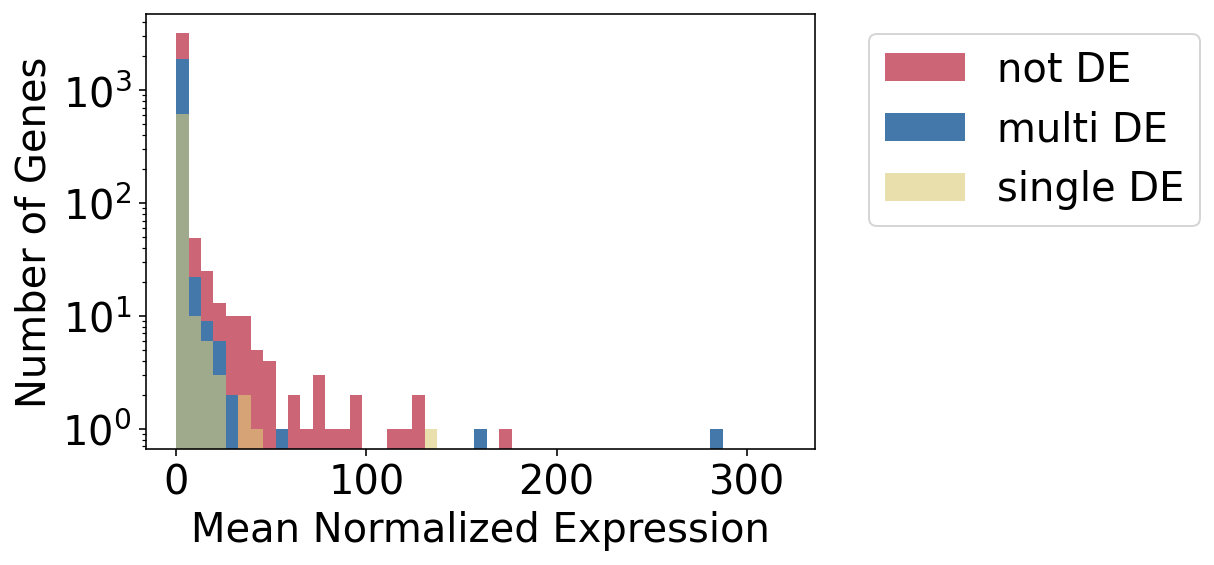

In [65]:
bins = np.linspace(0,320, 50)

fig, ax = plt.subplots()

plt.hist(notDE.X.mean(axis=0), bins = bins, color = '#CC6677', alpha = 1, label = 'not DE')
plt.hist(multi_adata.X.mean(axis=0), bins = bins, color = '#4477AA', alpha = 1, label = 'multi DE')
plt.hist(single_adata.X.mean(axis=0), bins = bins, color = '#DDCC77', alpha = 0.6, label = 'single DE')

ax.set_xlabel('Mean Normalized Expression')
ax.set_ylabel('Number of Genes')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc = "upper left")
plt.yscale('log')

## Acknowledgements

Thank you to Tara Chari for help with the UpSet plot, that code is from her [notebook](https://github.com/pachterlab/CWGFLHGCCHAP_2021/blob/691ab735fa03b834a05185faea4f36e0dfd461e5/notebooks/CellAtlasAnalysis/deSeq2Analysis_StarvationResponse.ipynb) accompanying the [preprint](https://www.biorxiv.org/content/10.1101/2021.01.22.427844v2), *Whole Animal Multiplexed Single-Cell RNA-Seq Reveals Transcriptional Shifts Across Clytia Medusae Cell Types* 